# COPERNICUS MARINE DATASET - THE NORTH SEA

# Feature importance analysis (using XGBoost)

https://help.marine.copernicus.eu/en/articles/8283072-copernicus-marine-toolbox-api-subset

https://pypi.org/project/copernicusmarine/

In [1]:
import copernicusmarine
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
#import shap
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import shap
from sklearn.inspection import permutation_importance
import seaborn as sns


# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

# Import Garbage Collector - we will need it a lot here, since we are dealing with huge files and might have memory issues!
import gc

c:\Users\fbale\anaconda3\envs\NewAtlantis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# You need to log in a Copernicus Marine account to access the data.
copernicusmarine.login()
# Copernicus username and password.

username:password:File C:\Users\fbale\.copernicusmarine\.copernicusmarine-credentials already exists, overwrite it ? [y/N]:

INFO - 2024-08-15T05:53:35Z - Credentials file stored in C:\Users\fbale\.copernicusmarine\.copernicusmarine-credentials.


True

# Import datasets as pandas dataframes (skip this if you already have merged_df.csv)

(Based on Kshitiz's code)

In [136]:
NORTH_SEA_REGION_lat = [50, 62]
NORTH_SEA_REGION_lon = [-6, 12]
TIMEFRAME = ["1997-01-01T00:00:00", "2023-01-01T00:00:00"]
DEPTH = [0, 0.5]

TIMEFRAMES_SST = [["1997-01-01T00:00:00", "2002-12-01T00:00:00"], ["2002-12-02T00:00:00", "2007-12-01T00:00:00"], ["2007-12-02T00:00:00", "2012-12-01T00:00:00"],
                  ["2012-12-02T00:00:00", "2017-12-01T00:00:00"], ["2017-12-02T00:00:00", "2023-01-01T00:00:00"]]

SST_COUNTER = 0

CURR_DIR = os.getcwd()
DATASETS_DIR = CURR_DIR + "\\datasets_csv"
os.makedirs(DATASETS_DIR, exist_ok = True)

In [4]:
def get_and_polish_dataset(dataset_id, variables, output_name, SST_COUNTER):
    HAS_DEPTH = {'bathy', 'carbon', 'chlorophyll', 'pisces'}
    
    if output_name in HAS_DEPTH:
        depth_ = DEPTH
    else:
        depth_ = [None, None]


    if (not output_name == 'bathy') and (not output_name == 'sst'):
        time_ = TIMEFRAME
    elif output_name == 'sst':
        time_ = TIMEFRAMES_SST[SST_COUNTER]
        output_name = output_name + '_' + str(SST_COUNTER)
    else:
        time_ = [None, None]

    data_request = {
    "dataset_id" : dataset_id,
    "variables" : variables,
    "longitude" : NORTH_SEA_REGION_lon, 
    "latitude" : NORTH_SEA_REGION_lat,
    "time" : time_,
    "depth": depth_
    } 

    if not output_name == 'bathy':
        df = copernicusmarine.read_dataframe(dataset_id=data_request["dataset_id"],
                                        variables=data_request["variables"],
                                        minimum_longitude=data_request["longitude"][0],
                                        maximum_longitude=data_request["longitude"][1],
                                        minimum_latitude=data_request["latitude"][0],
                                        maximum_latitude=data_request["latitude"][1],
                                        minimum_depth=data_request["depth"][0],
                                        maximum_depth=data_request["depth"][1],
                                        start_datetime=data_request["time"][0],
                                        end_datetime=data_request["time"][1]
                                        )
    else:
         df = copernicusmarine.read_dataframe(dataset_id=data_request["dataset_id"],
                                        variables=data_request["variables"],
                                        minimum_longitude=data_request["longitude"][0],
                                        maximum_longitude=data_request["longitude"][1],
                                        minimum_latitude=data_request["latitude"][0],
                                        maximum_latitude=data_request["latitude"][1],
                                        minimum_depth=data_request["depth"][0],
                                        maximum_depth=data_request["depth"][1]
                                        )

    df = df.dropna()


    # function to coarse grain the data and make resolution same as Pisces data
    def coarse_grain(df, features, output_name):
        """
            Parameters
            ----------
            df: pandas dataframe containing the data accessed from copernicus mariner
            features: name of the features in the dataframe

            Output
            ------
            a pandas dataframe with feature values for 0.25 deg x 0.25 deg resolution 

            """
        
        df["0_1"] = df["latitude"].to_numpy() - np.floor(df["latitude"])
        conditions = [df["0_1"] < 0.25,
                        (df["0_1"] >= 0.25)  & (df["0_1"] < 0.5),
                        (df["0_1"] >= 0.5)  & (df["0_1"] < 0.75),
                        (df["0_1"] >= 0.75)  & (df["0_1"] < 1)]
        outputs = [0, 0.25, 0.5, 0.75]
        df['latitude'] = np.floor(df["latitude"]) + np.select(conditions, outputs)
        df = df.drop(columns=["0_1"])

        df["0_1"] = df["longitude"].to_numpy() - np.floor(df["longitude"])
        # if not redefined then conditions is based on latitude
        conditions = [df["0_1"] < 0.25,
                    (df["0_1"] >= 0.25)  & (df["0_1"] < 0.5),
                    (df["0_1"] >= 0.5)  & (df["0_1"] < 0.75),
                    (df["0_1"] >= 0.75)  & (df["0_1"] < 1)]
        df['longitude'] = np.floor(df["longitude"]) + np.select(conditions, outputs)
        df = df.drop(columns=["0_1"])

        if not output_name == 'bathy': 
            return df.groupby(["time", "latitude", "longitude"])[features].mean()
        else:
            return df.groupby(["latitude", "longitude"])[features].mean()
    
    if not output_name == 'pisces':
        df = df.reset_index()
        if not output_name == 'bathy':
            df_cg = coarse_grain(df, df.columns[3:].tolist(), output_name)
        else:
            df_cg = coarse_grain(df, df.columns[2:].tolist(), output_name)
    else:
        # remove depth as index
        df = df.reset_index(level=["depth"])
        # average across the depth for each (time, latitude, longitude)
        df_cg = df.reset_index().groupby(["time","latitude","longitude"]).mean()
        df_cg = df_cg.drop(columns=["depth"])


    # remove time and just have month and year
    df_cg = df_cg.reset_index()

    if not output_name == 'bathy':
        # from https://stackoverflow.com/questions/53509168/extract-year-month-and-day-from-datetime64ns-utc-python
        datetimes = pd.to_datetime(df_cg['time'])
        df_cg['day'] = datetimes.dt.day
        df_cg['month'] = datetimes.dt.month
        df_cg['year'] = datetimes.dt.year

        # remove the time column
        df_cg = df_cg.drop(columns=["time"])
        df_cg = df_cg.set_index(["year","month","day","latitude","longitude"])
        df_cg = df_cg.groupby(["year","month","latitude","longitude"]).mean()
        try:
             df_cg = df_cg.drop(columns = ["day"])
        except: 
            pass

    df_cg.to_csv(f"{DATASETS_DIR}/{output_name}_049depth.csv")

    del df, df_cg
    gc.collect()

    return SST_COUNTER

In [5]:
bathy_info = { 'dataset_id': 'cmems_mod_glo_phy_my_0.083deg_static',
               'variables': ['deptho'],
               'output_name' : 'bathy'}

carbon_info = { 'dataset_id': 'dataset-carbon-rep-monthly',
               'variables': ["fgco2", "omega_ar", "omega_ca", "ph", "spco2", "talk", "tco2"],
               'output_name' : 'carbon'}

chlorophyll_info = { 'dataset_id': 'cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M',
               'variables': ["CHL"],
               'output_name' : 'chlorophyll'}

pisces_info = { 'dataset_id': 'cmems_mod_glo_bgc_my_0.25deg_P1M-m',
               'variables': ["fe", "no3", "o2", "po4", "si"],
               'output_name' : 'pisces'}

sssd_info = { 'dataset_id': 'cmems_obs-mob_glo_phy-sss_my_multi_P1M',
               'variables': ["sos","dos"],
               'output_name' : 'sssd'}

sst_info = { 'dataset_id': 'METOFFICE-GLO-SST-L4-REP-OBS-SST',
               'variables': ["analysed_sst"],
               'output_name' : 'sst'}

In [6]:
dataset_names = [bathy_info, carbon_info, chlorophyll_info, pisces_info, sst_info]
dataset_names = [carbon_info, chlorophyll_info, pisces_info, sst_info]
# For sssd, use Kshitiz's notebook directly.

In [7]:
for name in tqdm(dataset_names):
    if not name['output_name'] == 'sst':
        get_and_polish_dataset(name['dataset_id'], name['variables'], name['output_name'], SST_COUNTER)
    else:
        for _ in range(len(TIMEFRAMES_SST)):
            get_and_polish_dataset(name['dataset_id'], name['variables'], name['output_name'], SST_COUNTER)
            SST_COUNTER += 1


  0%|          | 0/4 [00:00<?, ?it/s]INFO - 2024-08-15T05:54:07Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-15T05:54:07Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-15T05:54:09Z - Service was not specified, the default one was selected: "arco-time-series"
WARNING - 2024-08-15T05:54:11Z - Some or all of your subset selection [1997-01-01 00:00:00, 2023-01-01 00:00:00] for the time dimension  exceed the dataset coordinates [1985-01-01 00:00:00, 2022-12-01 00:00:00]
 25%|██▌       | 1/4 [00:34<01:42, 34.16s/it]INFO - 2024-08-15T05:54:41Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-15T05:54:41Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-15T05:54:44Z - Service was not specified, the default one was selected: "arco-time-series"
WARNING - 2024-08-15T05:54:46Z - Some or all of your subset selection [1997-01-01 00:00:0

### Merge datasets together

In [8]:
df_sst = [pd.read_csv(f"{DATASETS_DIR}/sst_{i}_049depth.csv") for i in range(len(TIMEFRAMES_SST))]
df_sst = pd.concat(df_sst)

In [9]:
df_sst.head()

year  month  latitude  longitude  analysed_sst
0  1997      1      50.0      -6.00    282.574342
1  1997      1      50.0      -5.75    282.242026
2  1997      1      50.0      -5.50    281.981512
3  1997      1      50.0      -5.25    282.242816
4  1997      1      50.0      -5.00    282.143143

In [11]:
df_sst.to_csv(f"{DATASETS_DIR}/sst_049depth.csv")

In [18]:
all_df = []
for df in os.listdir(DATASETS_DIR):
    if not df.startswith('merged'):
        if not df.startswith('bathy'):
            all_df.append(pd.read_csv(f"{DATASETS_DIR}/{df}").set_index(["year", "month", "latitude", "longitude"]))
        #else:
        #    all_df.append(pd.read_csv(f"{DATASETS_DIR}/{df}").set_index(["latitude", "longitude"]))
[len(x) for x in all_df]

[502181, 632471, 629928, 587476, 726150]

In [19]:
# Some datasets still have an unnamed column corresponding to an indexing column that we need to drop
cleaned_all_df = []
for df in all_df:
    try:
        cleaned_all_df.append(df.drop(columns=['Unnamed: 0']))
    except:
        cleaned_all_df.append(df)

In [20]:
merged_df = cleaned_all_df[0]
for df in cleaned_all_df[1:]:
    merged_df = merged_df.join(df, how = 'inner')

In [21]:
merged_df.tail(5)

fgco2  omega_ar  omega_ca        ph  \
year month latitude longitude                                           
2021 12    55.75    6.75       1.473553  1.829214  2.891729  8.043766   
                    7.00       1.629428  1.791012  2.834707  8.044727   
                    7.25       1.773693  1.758312  2.785361  8.045312   
                    7.50       1.968011  1.731104  2.744416  8.046703   
                    7.75       2.076379  1.667038  2.647795  8.047576   

                                   spco2       talk       tco2       CHL  \
year month latitude longitude                                              
2021 12    55.75    6.75       401.20660  2253.8726  2092.1730  2.462389   
                    7.00       398.89398  2246.2212  2088.3820  3.094560   
                    7.25       397.25525  2243.0388  2088.3457  3.464520   
                    7.50       394.90198  2240.6643  2088.5774  3.270432   
                    7.75       391.79420  2230.0159  2084.4514  3.117513   

                                     fe       no3         o2       po4  \
year month latitude longitude                                            
2021 12    55.75    6.75       0.003070  0.747707  285.67290  0.069740   
                    7.00       0.003361  1.204397  289.18616  0.065487   
                    7.25       0.003699  1.786570  293.32886  0.060587   
                    7.50       0.004049  2.345498  298.00684  0.056399   
                    7.75       0.004550  3.298801  303.43777  0.059414   

                                      si        sos        dos  analysed_sst  
year month latitude longitude                                                 
2021 12    55.75    6.75        5.202378  32.930428  1025.5168    281.935013  
                    7.00        5.994682  32.734962  1025.4133    281.442690  
                    7.25        7.055422  32.547585  1025.3169    280.930626  
                    7.50        8.165790  32.393154  1025.2385    280.432226  
                    7.75       10.234082  32.237680  1025.1654    279.626665

In [22]:
len(merged_df)

426062

In [23]:
merged_df.to_csv(f"{DATASETS_DIR}/merged_df_049depth.csv")

In [24]:
del cleaned_all_df, all_df, df_sst
gc.collect()

0

# Retrieve merged dataframe (if you already had created merged_df.csv)

In [37]:
CURR_DIR = os.getcwd()
DATASETS_DIR = CURR_DIR + "\\datasets_csv"

In [38]:
merged_df = pd.read_csv(f"{DATASETS_DIR}\merged_df_049depth.csv")
len(merged_df)

426062

Min, max, average, std, 99th percentile values of chlorophyll in the merged dataframe: [0.07541559, 46.301, 0.9761236799999999, 1.364203859548165, 6.731882477000017]


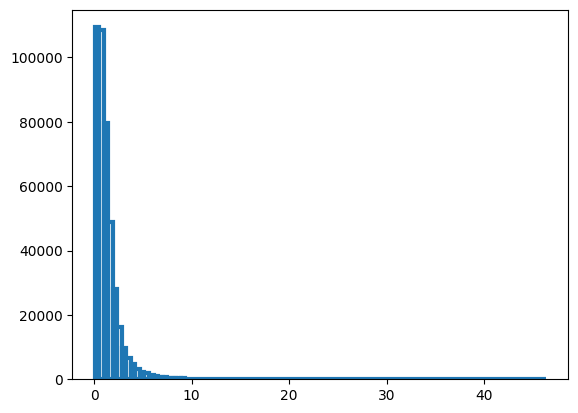

In [48]:
# Get rid of outliers for chlorophyll values
y = merged_df[['CHL']]
print("Min, max, average, std, 99th percentile values of chlorophyll in the merged dataframe:", 
      [y.min(axis=0)['CHL'], y.max(axis=0)['CHL'], y.median(axis=0)['CHL'], y.std()[0], np.percentile(y, 99)])

style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 3}
fig, ax = plt.subplots()
ax.hist(y, bins=100, **style)
plt.show()

In [59]:
# Get rid of values above the 99th percentile value
chl_threshold =  np.percentile(y, 99)
merged_df_chl_filtered = merged_df[merged_df["CHL"] < chl_threshold]
len(merged_df_chl_filtered)

421801

In [60]:
merged_df_original = merged_df.copy()
merged_df = merged_df_chl_filtered

Min, max, average, std, 99th percentile values of chlorophyll in the merged filtered dataframe: [0.07541559, 6.731405, 0.96548104, 1.027097082394752, 5.264961]


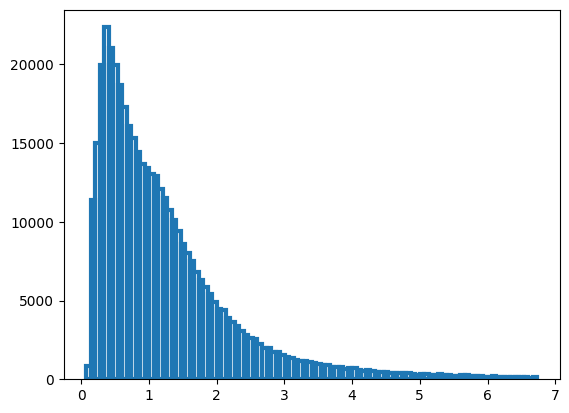

In [64]:
# Get rid of outliers for chlorophyll values
y = merged_df[['CHL']]
print("Min, max, average, std, 99th percentile values of chlorophyll in the merged filtered dataframe:", 
      [y.min(axis=0)['CHL'], y.max(axis=0)['CHL'], y.median(axis=0)['CHL'], y.std()[0], np.percentile(y, 99)])

style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 3}
fig, ax = plt.subplots()
ax.hist(y, bins=100, **style)
plt.show()

# Split data into train, val, test sets

In [65]:
# Extract feature and target arrays
X = merged_df.drop('CHL', axis = 1)
y = merged_df[['CHL']]
#X = X.drop('time', axis = 1)
#X = X.drop('latitude', axis = 1)
#X = X.drop('longitude', axis = 1)

del merged_df
gc.collect()

18100

In [67]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1729)
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, random_state = 1729)

del X_train, y_train
gc.collect()

0

In [94]:
# Save the train, val, and test sets
X_train_train.to_csv((f"{DATASETS_DIR}/X_train_train_049depth.csv"))
y_train_train.to_csv((f"{DATASETS_DIR}/y_train_train_049depth.csv"))
X_train_test.to_csv((f"{DATASETS_DIR}/X_train_test_049depth.csv"))
y_train_test.to_csv((f"{DATASETS_DIR}/y_train_test_049depth.csv"))
X_test.to_csv((f"{DATASETS_DIR}/X_test_049depth.csv"))
y_test.to_csv((f"{DATASETS_DIR}/y_test_049depth.csv"))

# Grid search for XGBoost Regression

This can take quite long (about 100-120 mins) depending on the parameters

In [72]:
grid_model = XGBRegressor(n_estimators = 5000, 
                          verbosity = 0, 
                          random_state = 1729, 
                          learning_rate = 0.1,
                          max_depth = 7,
                          early_stopping_rounds = 50,  
                          subsample = 0.9,  # Subsample ratio of the training instances
                          colsample_bytree = 0.8, 
                          device = 'cuda')
param_grid = {
    'max_depth': [6, 7, 8],
    'learning_rate': [0.1],
    'subsample' : [0.8, 0.9, 1],
    'colsample_bytree' : [0.7, 0.8, 0.9],
    #'n_estimators': [1000, 2000, 4000]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator = grid_model,
                           param_grid = param_grid,
                           cv = 5,
                           scoring = 'neg_mean_squared_error'

)

# Fit the grid search to the training data
grid_search.fit(X_train_train, y_train_train, eval_set = [(X_train_train, y_train_train), (X_train_test, y_train_test)], verbose = False)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new model with the best parameters
best_model = XGBRegressor(**best_params)

# Train the best model
best_model.fit(X_train_train, y_train_train, eval_set = [(X_train_train, y_train_train), (X_train_test, y_train_test)], verbose = False)

# Make predictions on the test set
y_pred_best = best_model.predict(X_train_test)

# Evaluate the best model
mse_best = mean_squared_error(y_pred = y_pred_best, y_true = y_train_test)
print(f"MSE with Best Parameters: {mse_best:.5f}")
print(f"RMSE with Best Parameters: {np.sqrt(mse_best):.5f}")

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'subsample': 0.8}
MSE with Best Parameters: 0.15499
RMSE with Best Parameters: 0.39368


### Results after XGBoost grid search:

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'subsample': 0.8} <br> 

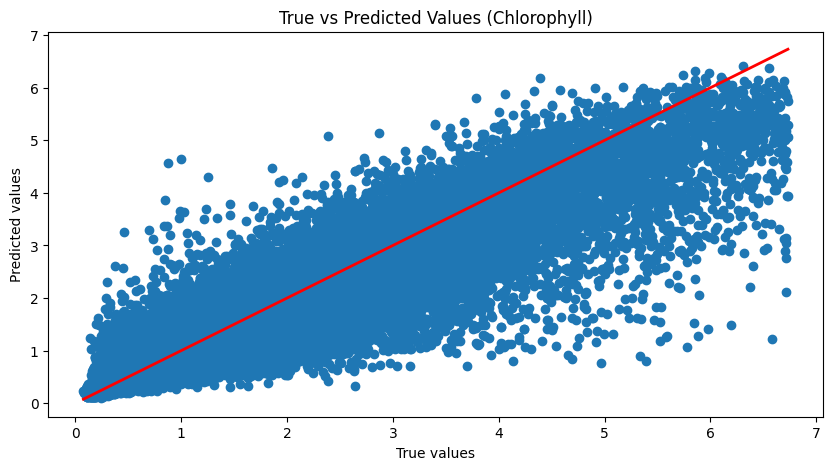

In [79]:
predictions = best_model.predict(X_test)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red',  linewidth=2)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True vs Predicted Values (Chlorophyll)')
plt.show()

# XGBoost best model

After messing around a bit with grid search and just manual tuning, the best I can do is an RMSE of 0.39288 with these parameters:

XGBRegressor(n_estimators = 20000, 
                          learning_rate = 0.1,
                          max_depth = 7,
                          verbosity = 0, 
                          random_state = 1729, 
                          early_stopping_rounds = 50,  
                          subsample = 0.9,  # Subsample ratio of the training instances
                          colsample_bytree = 0.8, 
                          device = 'cuda')

In [78]:
xgb_best_model = XGBRegressor(n_estimators = 6000, 
                          learning_rate = 0.1,
                          max_depth = 8,
                          verbosity = 0, 
                          random_state = 1729, 
                          early_stopping_rounds = 50,  
                          subsample = 0.8,  # Subsample ratio of the training instances
                          colsample_bytree = 0.9, 
                          device = 'cuda')
xgb_best_model.fit(X_train_train, y_train_train, eval_set = [(X_train_train, y_train_train), (X_train_test, y_train_test)], verbose = True)

[0]	validation_0-rmse:0.95904	validation_1-rmse:0.96379
[1]	validation_0-rmse:0.90469	validation_1-rmse:0.90974
[2]	validation_0-rmse:0.84969	validation_1-rmse:0.85499
[3]	validation_0-rmse:0.80191	validation_1-rmse:0.80769
[4]	validation_0-rmse:0.75870	validation_1-rmse:0.76487
[5]	validation_0-rmse:0.72190	validation_1-rmse:0.72867
[6]	validation_0-rmse:0.68909	validation_1-rmse:0.69633
[7]	validation_0-rmse:0.66145	validation_1-rmse:0.66926
[8]	validation_0-rmse:0.63577	validation_1-rmse:0.64424
[9]	validation_0-rmse:0.61433	validation_1-rmse:0.62360
[10]	validation_0-rmse:0.59404	validation_1-rmse:0.60380
[11]	validation_0-rmse:0.57709	validation_1-rmse:0.58765
[12]	validation_0-rmse:0.56188	validation_1-rmse:0.57303
[13]	validation_0-rmse:0.54842	validation_1-rmse:0.56020
[14]	validation_0-rmse:0.53700	validation_1-rmse:0.54961
[15]	validation_0-rmse:0.52593	validation_1-rmse:0.53917
[16]	validation_0-rmse:0.51611	validation_1-rmse:0.52999
[17]	validation_0-rmse:0.50763	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device='cuda', early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=6000, n_jobs=None,
             num_parallel_tree=None, random_state=1729, ...)

In [85]:
y_pred_best = xgb_best_model.predict(X_train_test)
y_pred_best = y_pred_best.reshape(-1, 1)

# MAPE (MEAN ABSOLUTE PERCENTAGE ERROR)
print("MAPE: ", np.mean(((y_pred_best-y_train_test)/y_train_test).apply(abs)))
# Evaluate the best model
mse_best = mean_squared_error(y_pred = y_pred_best, y_true = y_train_test)
print(f"MSE with Best Parameters: {mse_best:.5f}")
print(f"RMSE with Best Parameters: {np.sqrt(mse_best):.5f}")

MAPE:  0.1270862961963413
MSE with Best Parameters: 0.07803
RMSE with Best Parameters: 0.27934


In [86]:
# True standard deviation
y_train_test.std()[0]

1.032096481381076

In [87]:
true_sd = y_train_test.std()[0]
correct = 0
for i, c in enumerate(y_pred_best):
    correct += int(abs(y_train_test.values[i]-c) < true_sd)
proportion_within_one_std = correct/len(y_pred_best)
print(proportion_within_one_std)

0.9870271090430912


In [88]:
xgb_best_model.save_model("xgb_best_search_grid_model_merged_df_north_sea_049depth.json")

# Set up folder for storing the various feature importance plots for XGBoost

In [89]:
CURR_DIR = os.getcwd()

DATASET_NAME = "best_xgboost_merged_df_north_sea_049depth"

feat_imp_plots_path = CURR_DIR + f"\\feat_imp_plots_{DATASET_NAME}\\"
if not os.path.exists(feat_imp_plots_path):
    os.mkdir(feat_imp_plots_path)

shap_plots_path = CURR_DIR + f"\\shap_plots_{DATASET_NAME}\\"
if not os.path.exists(shap_plots_path):
    os.mkdir(shap_plots_path)

permutation_imp_plots_path = CURR_DIR + f"\\permutation_imp_plots_{DATASET_NAME}\\"
if not os.path.exists(permutation_imp_plots_path):
    os.mkdir(permutation_imp_plots_path)

# Feature importance: WEIGHT, GAIN, COVER

For XGBoost, we are consider the following three feature importance types: WEIGHT, GAIN, and COVER. For more explanation, see  https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7 .
We are going to select the features from the training set (and not the whole set); see e.g. https://stackoverflow.com/questions/56308116/should-feature-selection-be-done-before-train-test-split-or-after


In [90]:
def create_feature_importance_type_df(model, FEATURE_CONSIDERED):
    list_feat = list(model.get_booster().get_score(importance_type = FEATURE_CONSIDERED).items())
    feat_df = pd.DataFrame(list_feat, columns=['feature',f'importance ({FEATURE_CONSIDERED})']).sort_values(f'importance ({FEATURE_CONSIDERED})', ascending = False)
    total = feat_df[f"importance ({FEATURE_CONSIDERED})"].sum()
    feat_df["proportion"] = feat_df[f"importance ({FEATURE_CONSIDERED})"].div(total)
    gc.collect()
    return feat_df, list_feat

In [91]:
def plot_feature_importance(model, FEATURE_CONSIDERED, COLOUR, save_plot_path):

    df, _ = create_feature_importance_type_df(model, FEATURE_CONSIDERED)


    df = df.set_index('feature').sort_values('proportion')
    top_features = df.index.to_list() # The order right now is revers [fifth, fourth, ..., second, first]
    top_features.reverse()

    # Build horizontal bar char
    ax = df.plot.barh(color=COLOUR, alpha=0.5, grid=True, legend=False, title=f'Feature importance ({FEATURE_CONSIDERED})', figsize=(15, 5))

    # Annotate bar chart, adapted from this SO answer:
    # https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
    for p, value in zip(ax.patches, df['proportion']):
        ax.annotate(round(value, 2), (p.get_width() * 1.005, p.get_y() * 1.005))
    
    plt.savefig(save_plot_path + f"\\plot_feat_importance_{FEATURE_CONSIDERED}.png")

    gc.collect()
    return top_features

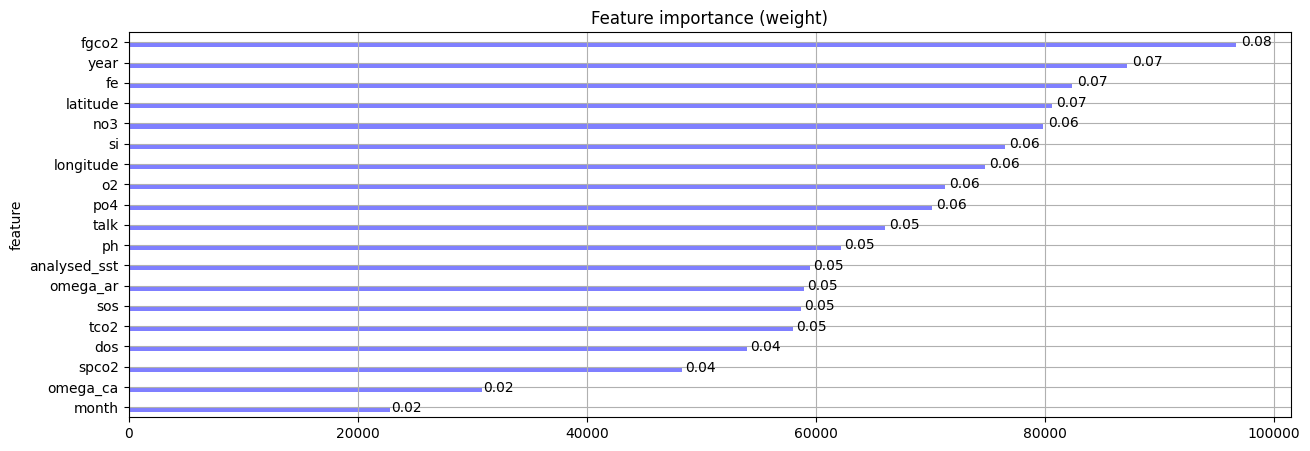

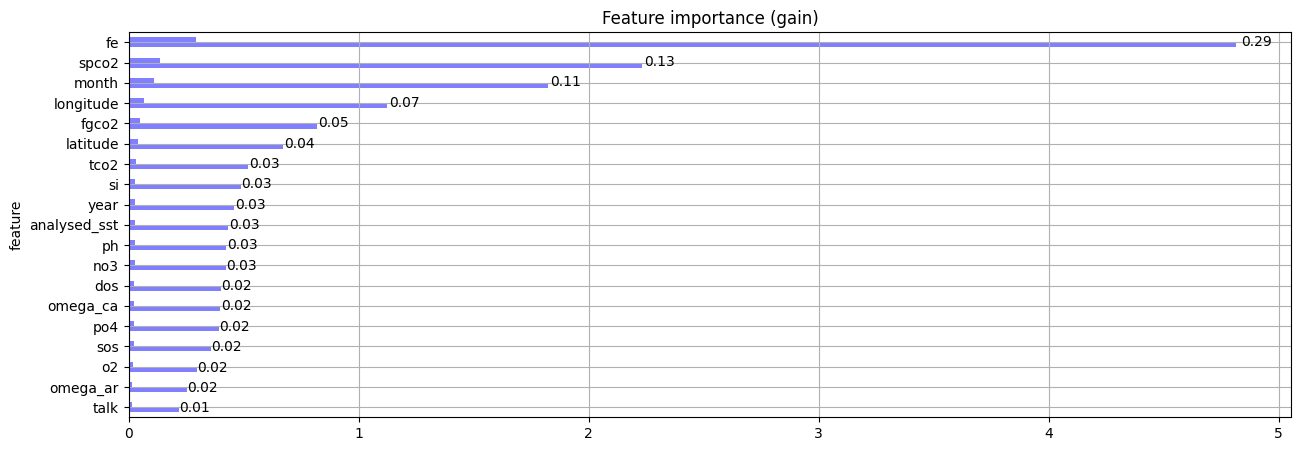

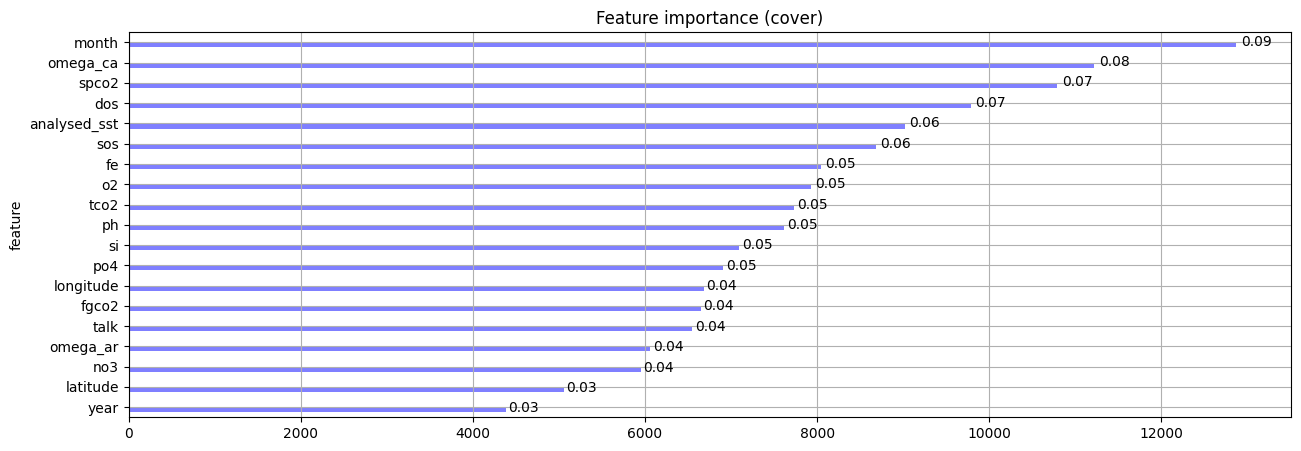

In [92]:
FEAT_IMP_TYPES = ["weight", "gain", "cover"]
# Remember the top features for each of WEIGHT, GAIN, COVER
top_features = []

for feat_imp_type in FEAT_IMP_TYPES:
    top = plot_feature_importance(xgb_best_model, feat_imp_type, "blue", feat_imp_plots_path)
    top_features.append([feat_imp_type, top])
    gc.collect()

# Feature importance: SHAP

In [93]:
explainer = shap.TreeExplainer(xgb_best_model, feature_perturbation= 'tree_path_dependent')
shap_values = explainer.shap_values(X_train_test)
gc.collect()

45

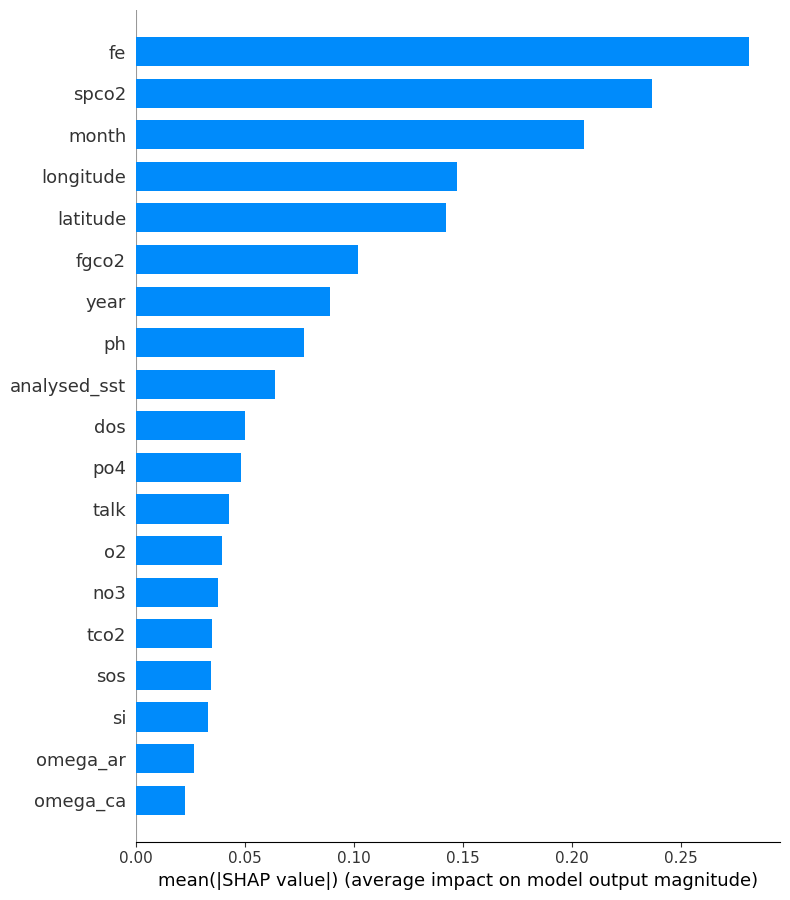

In [95]:
shap.summary_plot(shap_values, X_train_test, plot_type = "bar", show = False)
plt.savefig(shap_plots_path +  "\\shap_bar_plot.png")
plt.show()

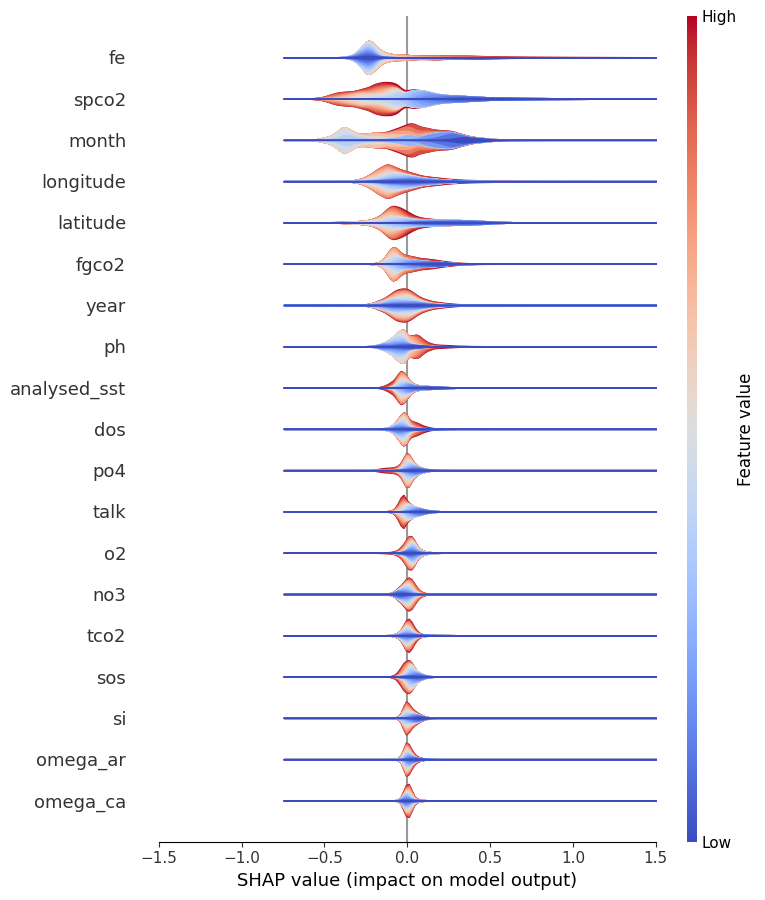

In [96]:
feat_names = list(X_train_test.columns)
shap.summary_plot(shap_values, X_train_test, feature_names = feat_names, plot_type = "layered_violin", show = False)
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/violin.html
ax = plt.gca()
ax.set_xlim(-1.5, 1.5)
plt.savefig(shap_plots_path + "\\shap_layered_violin_plot.png")
plt.show()

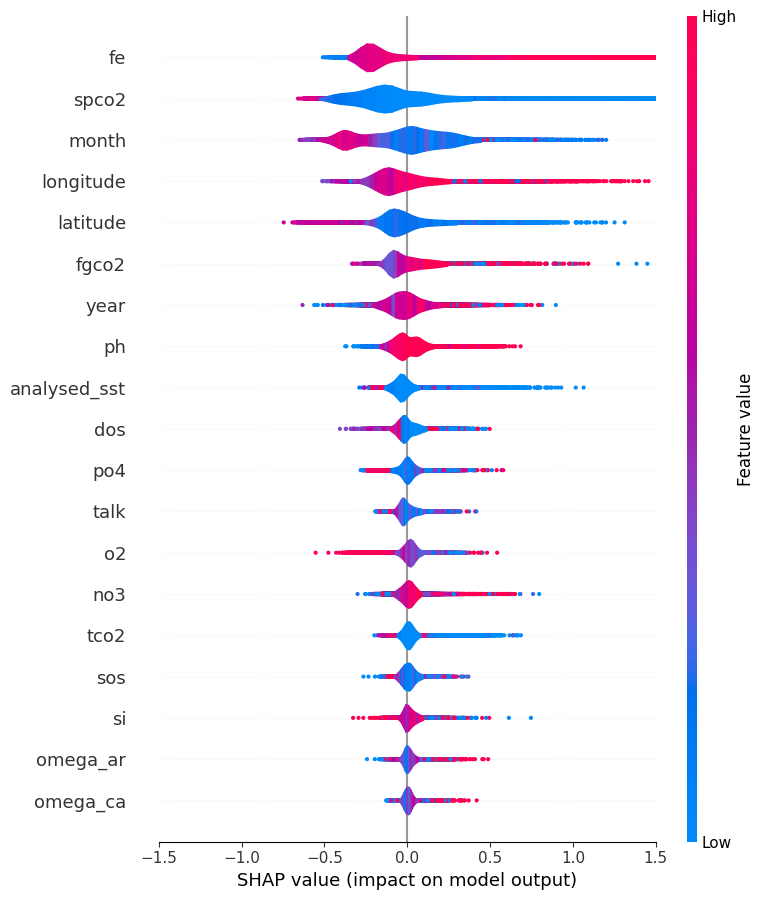

In [97]:
feat_names = list(X_train_test.columns)
shap.summary_plot(shap_values, X_train_test, feature_names = feat_names, plot_type = "violin", show = False)
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/violin.html
ax = plt.gca()
ax.set_xlim(-1.5, 1.5)
plt.savefig(shap_plots_path + "\\shap_layered_violin_plot.png")
plt.show()

In [130]:
shap_values_NAL = explainer(X_train_test)

In [132]:
# Visualize the first prediction's explanation
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values_NAL[0].values, X_train_test.iloc[0, :])

In [133]:
shap_values_explanation = shap.Explanation(shap_values_NAL, base_values=shap_values_NAL.base_values, data=X_train_test, feature_names=X_train_test.columns)

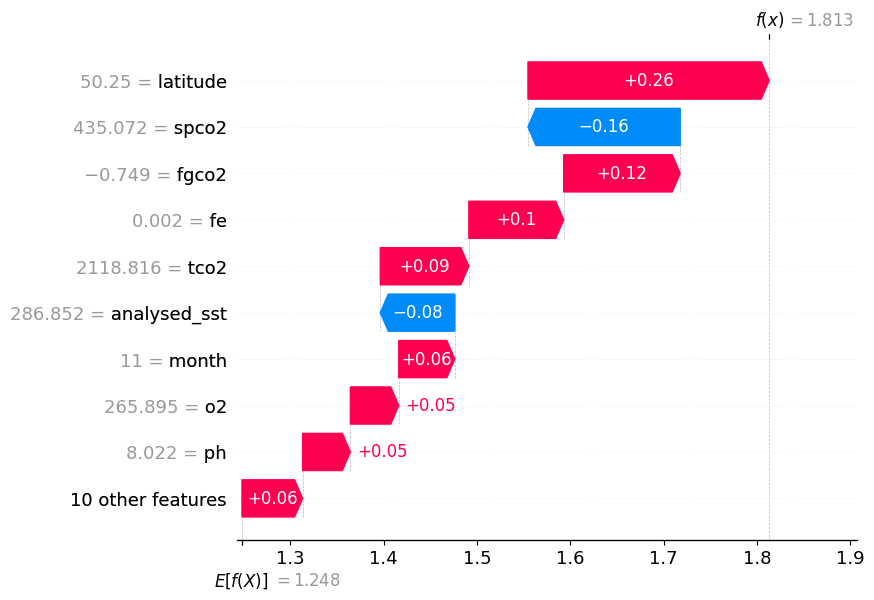

In [134]:
# Waterfall plot for a first instance
shap.waterfall_plot(shap_values_explanation[0])
plt.show()

In [135]:
gc.collect()

61508

#### Plot shap dependency plots

In [101]:
# Plot the graph shap_values vs actual values
# Consider the top k features that might interact with the selected feature, and draw plots
def plot_shap_dependency_top_k(shap_values, X, FEATURE, k, save_plots, out_save_path):
    inds = shap.approximate_interactions(FEATURE, shap_values, X)
    # make plots colored by each of the top three possible interacting features
    for i in range(k):
        shap.dependence_plot(FEATURE, shap_values, X, interaction_index = inds[i], show = False)
        if save_plots:
            plt.savefig(out_save_path + f'\\shap_dependency_plot_{FEATURE}_{i}.png')
        plt.show()
        gc.collect()

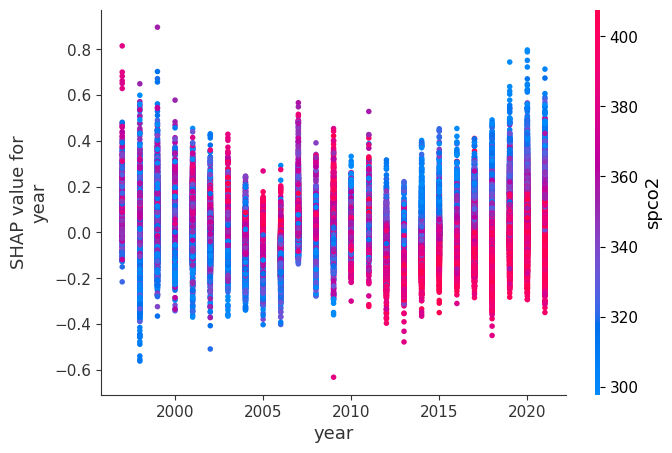

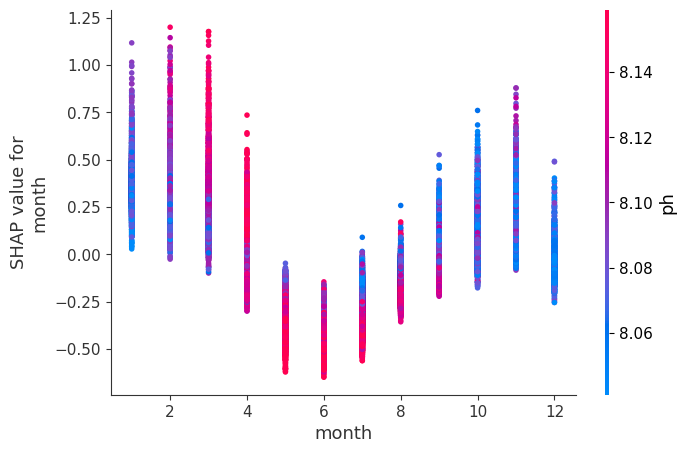

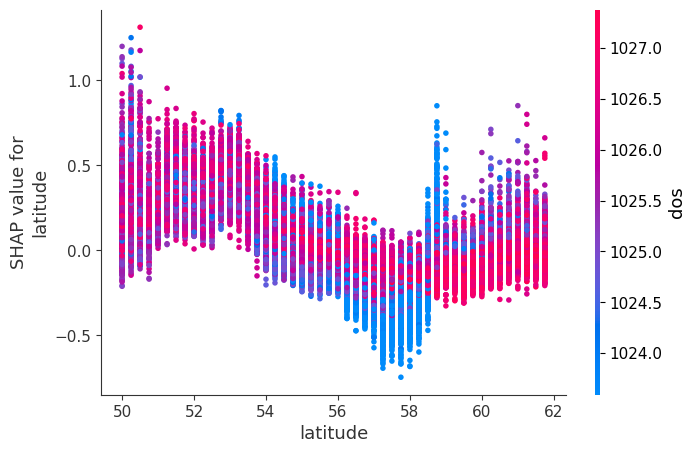

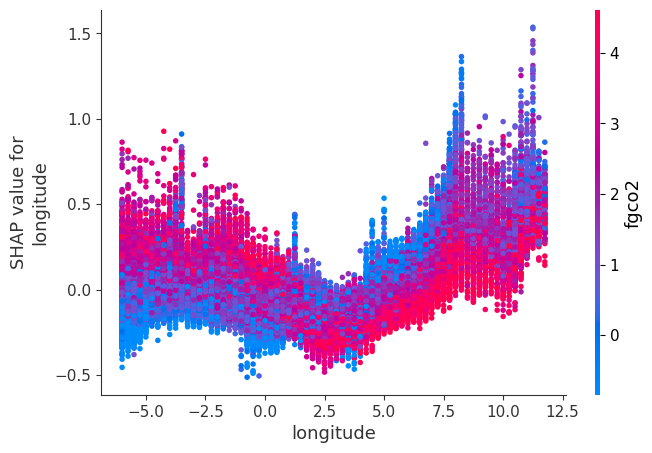

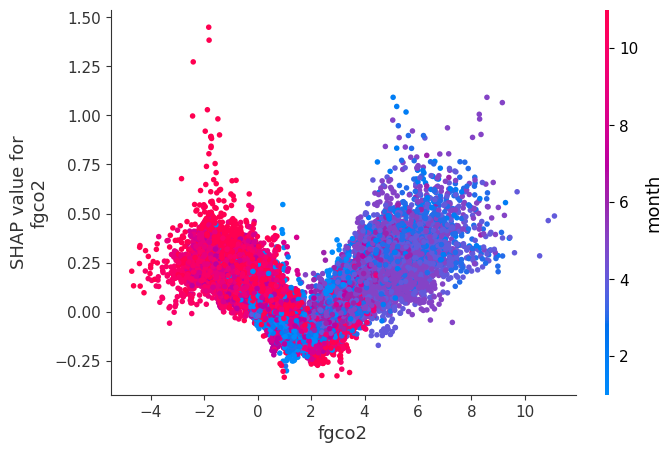

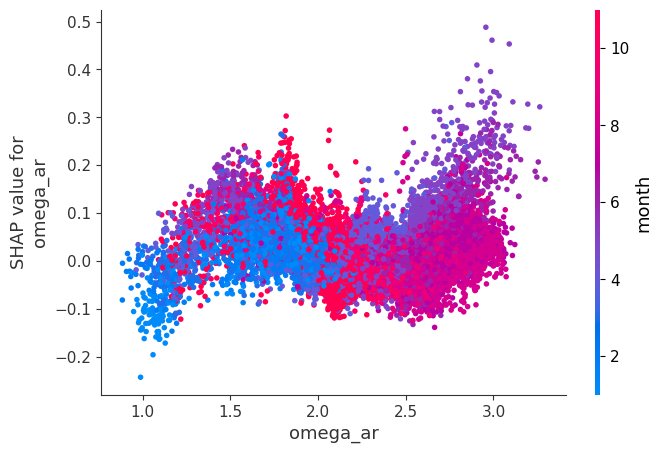

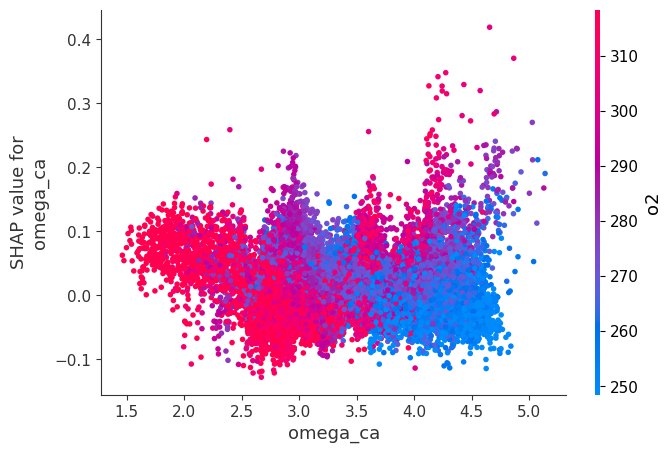

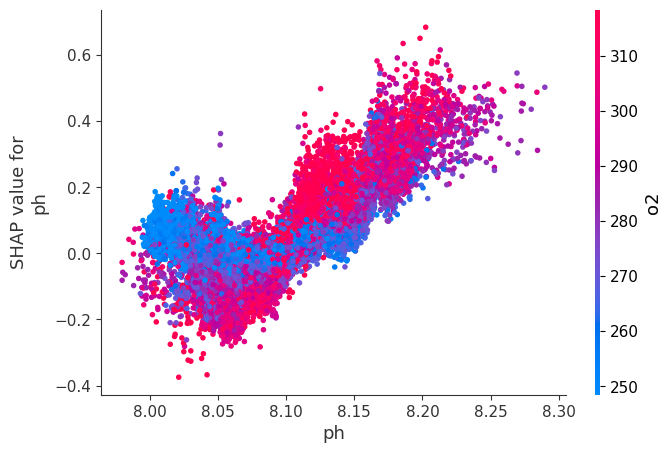

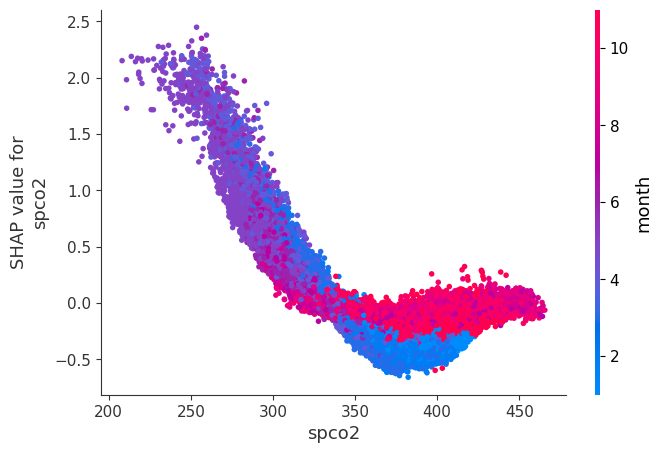

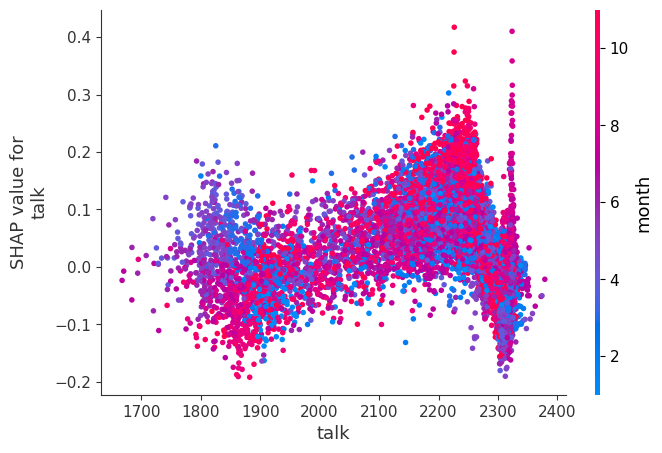

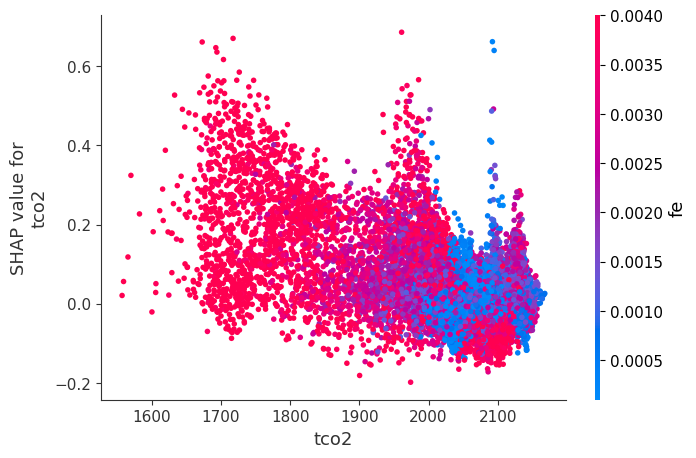

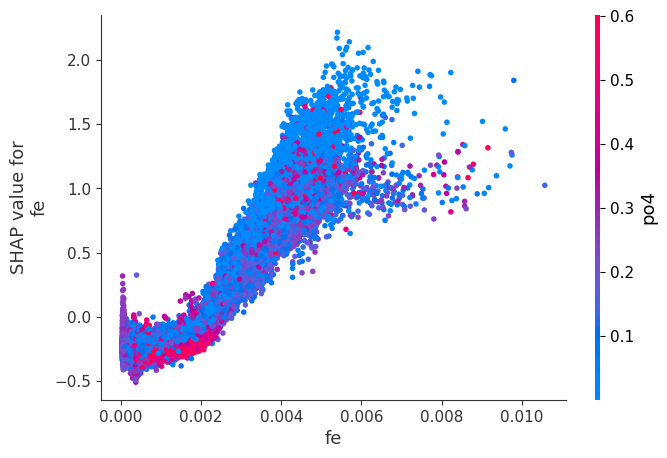

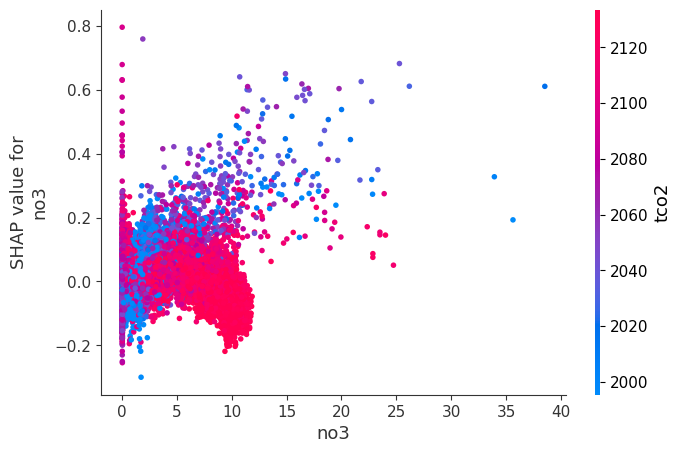

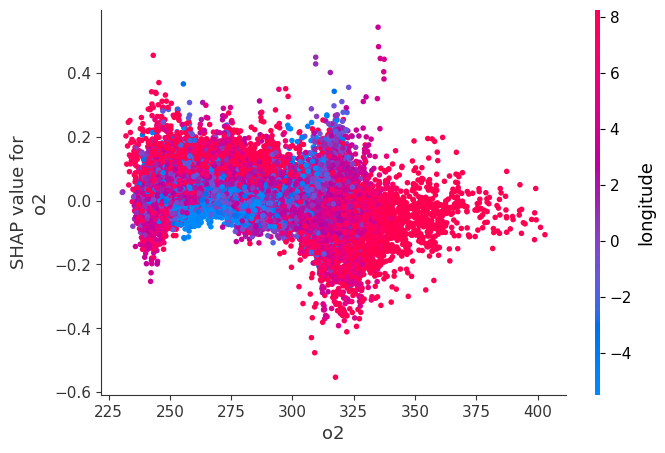

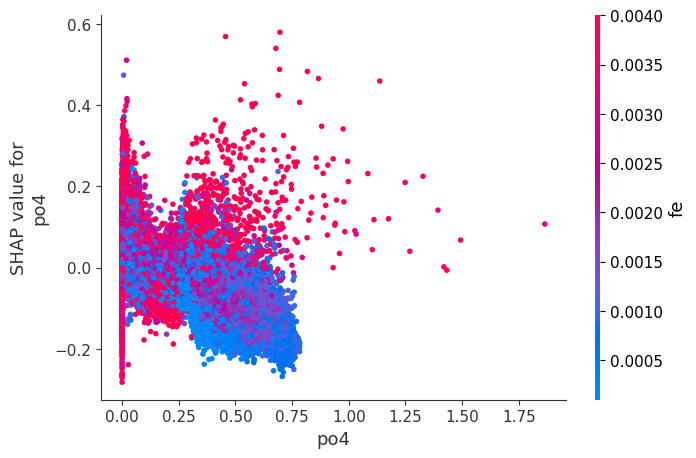

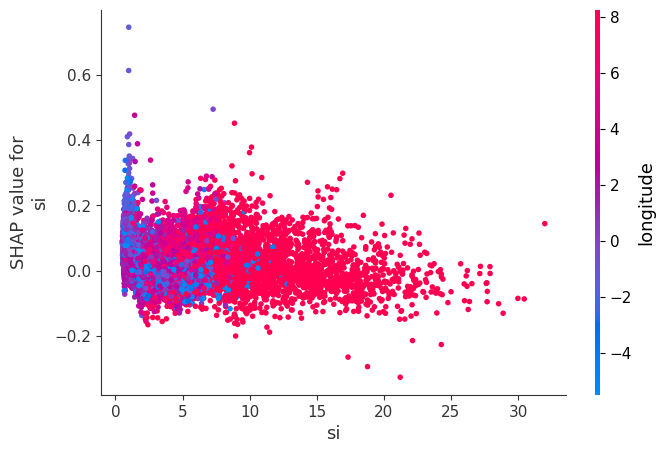

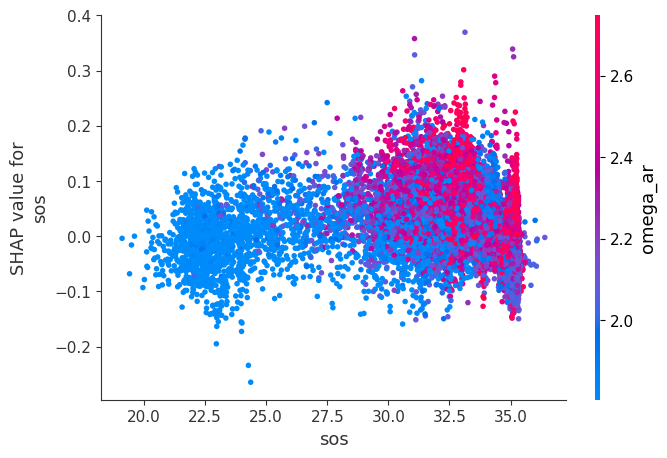

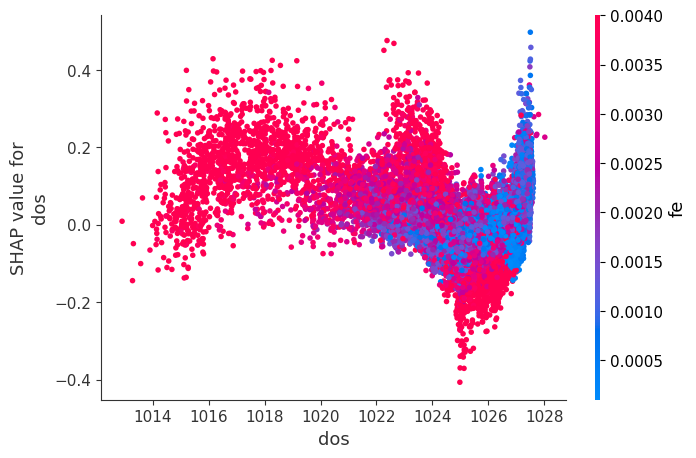

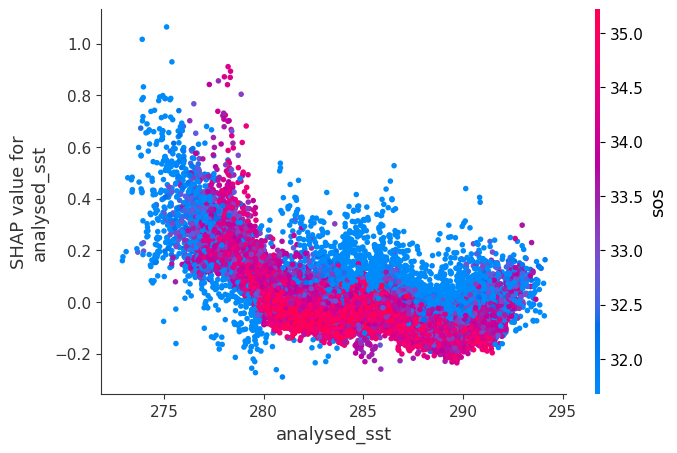

In [102]:
feat_names = list(X_train_test.columns)

for feat_name in feat_names:
    plot_shap_dependency_top_k(shap_values, X_train_test, feat_name, 1, True, shap_plots_path)
    gc.collect()

# Feature importance: permutation feature importance

https://christophm.github.io/interpretable-ml-book/feature-importance.html

https://mljar.com/blog/feature-importance-xgboost/

In [103]:
perm_importance = permutation_importance(xgb_best_model, X_train_test, y_train_test)
feat_names = list(X_train_test.columns)
feat_names

['year',
 'month',
 'latitude',
 'longitude',
 'fgco2',
 'omega_ar',
 'omega_ca',
 'ph',
 'spco2',
 'talk',
 'tco2',
 'fe',
 'no3',
 'o2',
 'po4',
 'si',
 'sos',
 'dos',
 'analysed_sst']

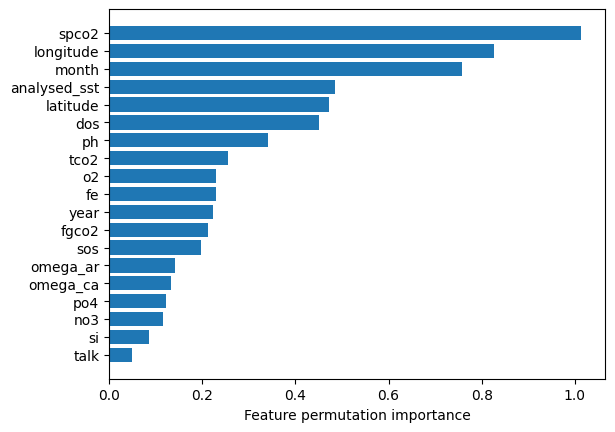

In [104]:
sorted_idx = perm_importance.importances_mean.argsort()
feat_names_sorted = [feat_names[i] for i in sorted_idx]
plt.barh(feat_names_sorted, perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature permutation importance")
plt.savefig(permutation_imp_plots_path + f"\\permutation_importance_plot.png")

In [105]:
def correlation_heatmap(X_train_feats, plots_save_path): 
    correlations = X_train_feats.corr()
    _, _ = plt.subplots(figsize = (12, 12))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.2f', cmap = "YlGnBu", square = True, linewidths = 0.5, annot = True, cbar_kws = {"shrink": .70})
    plt.savefig(plots_save_path + f"\\permutation_importance_heatmap.png")
    plt.show()

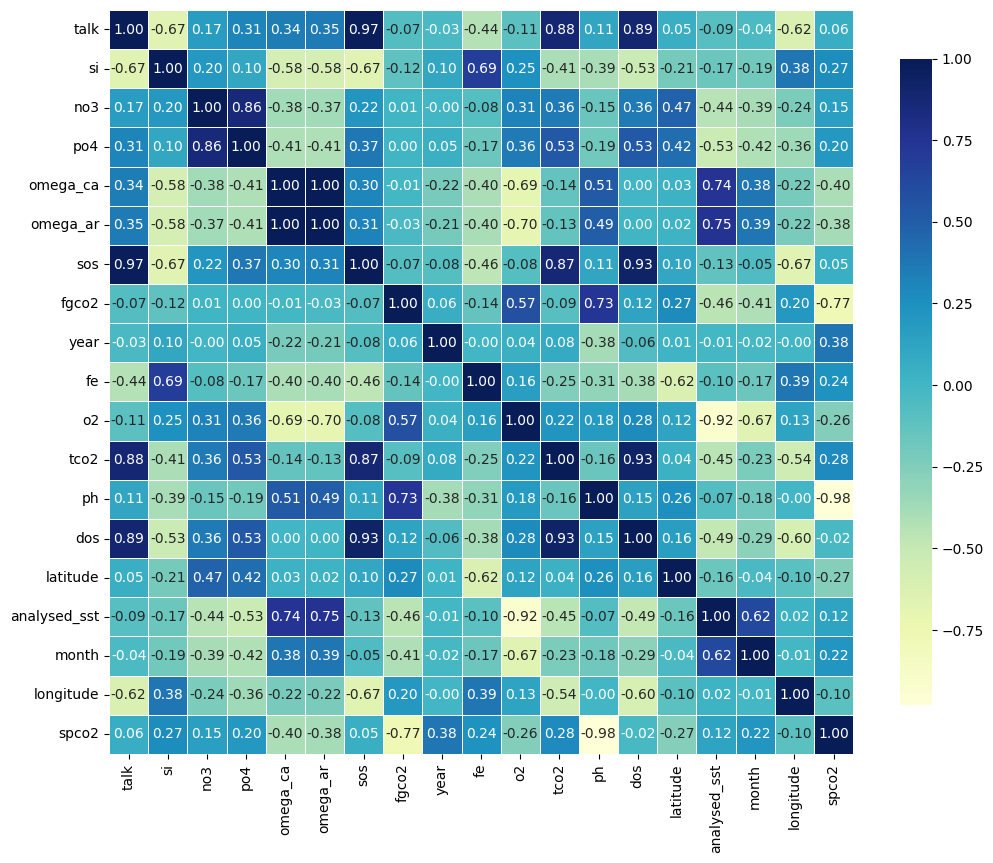

In [106]:
correlation_heatmap(X_train_train[feat_names_sorted], permutation_imp_plots_path)

# List of top 5 important features for XGBoost for each of the methods above

The ordering of the lists are [first, second, third, ...]

In [107]:
ALL_TOP_FEAT = []

In [108]:
time_features = {'month', 'year'}
position_features = {'longitude', 'latitude'}

def get_top_k_with_without_time_position(ordering, k, with_time, with_position):
    new_ordering = []
    for i in range(len(ordering)):
        append_element = True
        if (not with_time) and (ordering[i] in time_features):
            append_element = False
        if (not with_position) and (ordering[i] in position_features):
            append_element = False
        if append_element:
            new_ordering.append(ordering[i])
    ALL_TOP_FEAT.append(new_ordering[:k])
    return new_ordering[:k]   

In [109]:
def print_top_k_features(name_method, k, top_feat):
    print(f"{name_method} TOP {k} FEATURES")
    print(f"Top {k} (including position and time):")
    print(get_top_k_with_without_time_position(top_feat, k, with_time=True, with_position=True))
    print(f"Top {k} (excluding position, including time):")
    print(get_top_k_with_without_time_position(top_feat, k, with_time=True, with_position=False))
    print(f"Top {k} (including position, excluding time):")
    print(get_top_k_with_without_time_position(top_feat, k, with_time=False, with_position=True))
    print(f"Top {k} (excluding position and time):")
    print(get_top_k_with_without_time_position(top_feat, k, with_time=False, with_position=False))
    print("")

### **"Normal" feature importance**

In [110]:
for x in top_features:
    print(x)

['weight', ['fgco2', 'year', 'fe', 'latitude', 'no3', 'si', 'longitude', 'o2', 'po4', 'talk', 'ph', 'analysed_sst', 'omega_ar', 'sos', 'tco2', 'dos', 'spco2', 'omega_ca', 'month']]
['gain', ['fe', 'spco2', 'month', 'longitude', 'fgco2', 'latitude', 'tco2', 'si', 'year', 'analysed_sst', 'ph', 'no3', 'dos', 'omega_ca', 'po4', 'sos', 'o2', 'omega_ar', 'talk']]
['cover', ['month', 'omega_ca', 'spco2', 'dos', 'analysed_sst', 'sos', 'fe', 'o2', 'tco2', 'ph', 'si', 'po4', 'longitude', 'fgco2', 'talk', 'omega_ar', 'no3', 'latitude', 'year']]


In [111]:
weight_top_feat = top_features[0][1]
gain_top_feat = top_features[1][1]
cover_top_feat = top_features[2][1]

In [112]:
print_top_k_features("WEIGHT", 5, weight_top_feat)
print_top_k_features("GAIN", 5, gain_top_feat)
print_top_k_features("COVER", 5, cover_top_feat)

WEIGHT TOP 5 FEATURES
Top 5 (including position and time):
['fgco2', 'year', 'fe', 'latitude', 'no3']
Top 5 (excluding position, including time):
['fgco2', 'year', 'fe', 'no3', 'si']
Top 5 (including position, excluding time):
['fgco2', 'fe', 'latitude', 'no3', 'si']
Top 5 (excluding position and time):
['fgco2', 'fe', 'no3', 'si', 'o2']

GAIN TOP 5 FEATURES
Top 5 (including position and time):
['fe', 'spco2', 'month', 'longitude', 'fgco2']
Top 5 (excluding position, including time):
['fe', 'spco2', 'month', 'fgco2', 'tco2']
Top 5 (including position, excluding time):
['fe', 'spco2', 'longitude', 'fgco2', 'latitude']
Top 5 (excluding position and time):
['fe', 'spco2', 'fgco2', 'tco2', 'si']

COVER TOP 5 FEATURES
Top 5 (including position and time):
['month', 'omega_ca', 'spco2', 'dos', 'analysed_sst']
Top 5 (excluding position, including time):
['month', 'omega_ca', 'spco2', 'dos', 'analysed_sst']
Top 5 (including position, excluding time):
['omega_ca', 'spco2', 'dos', 'analysed_sst',

### **SHAP feature importance**

In [113]:
shap_top_feat = X_train_test.columns[np.argsort(np.abs(shap_values).mean(0))].to_list().copy()
shap_top_feat.reverse()
print(shap_top_feat)

['fe', 'spco2', 'month', 'longitude', 'latitude', 'fgco2', 'year', 'ph', 'analysed_sst', 'dos', 'po4', 'talk', 'o2', 'no3', 'tco2', 'sos', 'si', 'omega_ar', 'omega_ca']


In [114]:
print_top_k_features("SHAP", 5, shap_top_feat)

SHAP TOP 5 FEATURES
Top 5 (including position and time):
['fe', 'spco2', 'month', 'longitude', 'latitude']
Top 5 (excluding position, including time):
['fe', 'spco2', 'month', 'fgco2', 'year']
Top 5 (including position, excluding time):
['fe', 'spco2', 'longitude', 'latitude', 'fgco2']
Top 5 (excluding position and time):
['fe', 'spco2', 'fgco2', 'ph', 'analysed_sst']



### **Permutation feature importance**

In [115]:
perm_top_feat = feat_names_sorted.copy()
perm_top_feat.reverse()
print(perm_top_feat)

['spco2', 'longitude', 'month', 'analysed_sst', 'latitude', 'dos', 'ph', 'tco2', 'o2', 'fe', 'year', 'fgco2', 'sos', 'omega_ar', 'omega_ca', 'po4', 'no3', 'si', 'talk']


In [116]:
print_top_k_features("PERMUTATION", 5, perm_top_feat)

PERMUTATION TOP 5 FEATURES
Top 5 (including position and time):
['spco2', 'longitude', 'month', 'analysed_sst', 'latitude']
Top 5 (excluding position, including time):
['spco2', 'month', 'analysed_sst', 'dos', 'ph']
Top 5 (including position, excluding time):
['spco2', 'longitude', 'analysed_sst', 'latitude', 'dos']
Top 5 (excluding position and time):
['spco2', 'analysed_sst', 'dos', 'ph', 'tco2']



### Features appearing in any of the top 5 lists above

In [117]:
ALL_TOP_FEAT

[['fgco2', 'year', 'fe', 'latitude', 'no3'],
 ['fgco2', 'year', 'fe', 'no3', 'si'],
 ['fgco2', 'fe', 'latitude', 'no3', 'si'],
 ['fgco2', 'fe', 'no3', 'si', 'o2'],
 ['fe', 'spco2', 'month', 'longitude', 'fgco2'],
 ['fe', 'spco2', 'month', 'fgco2', 'tco2'],
 ['fe', 'spco2', 'longitude', 'fgco2', 'latitude'],
 ['fe', 'spco2', 'fgco2', 'tco2', 'si'],
 ['month', 'omega_ca', 'spco2', 'dos', 'analysed_sst'],
 ['month', 'omega_ca', 'spco2', 'dos', 'analysed_sst'],
 ['omega_ca', 'spco2', 'dos', 'analysed_sst', 'sos'],
 ['omega_ca', 'spco2', 'dos', 'analysed_sst', 'sos'],
 ['fe', 'spco2', 'month', 'longitude', 'latitude'],
 ['fe', 'spco2', 'month', 'fgco2', 'year'],
 ['fe', 'spco2', 'longitude', 'latitude', 'fgco2'],
 ['fe', 'spco2', 'fgco2', 'ph', 'analysed_sst'],
 ['spco2', 'longitude', 'month', 'analysed_sst', 'latitude'],
 ['spco2', 'month', 'analysed_sst', 'dos', 'ph'],
 ['spco2', 'longitude', 'analysed_sst', 'latitude', 'dos'],
 ['spco2', 'analysed_sst', 'dos', 'ph', 'tco2']]

In [118]:
ALL_TOP_FEAT_YESTIME_YESPOS = []
ALL_TOP_FEAT_YESTIME_NOPOS = []
ALL_TOP_FEAT_NOTIME_YESPOS = []
ALL_TOP_FEAT_NOTIME_NOPOS = []
for i in range(len(ALL_TOP_FEAT)):
    if (i % 4 == 0):
        ALL_TOP_FEAT_YESTIME_YESPOS.append(ALL_TOP_FEAT[i])
    elif (i % 4 == 1):
        ALL_TOP_FEAT_YESTIME_NOPOS.append(ALL_TOP_FEAT[i])
    elif (i % 4 == 2):
        ALL_TOP_FEAT_NOTIME_YESPOS.append(ALL_TOP_FEAT[i])
    elif (i % 4 == 3):
        ALL_TOP_FEAT_NOTIME_NOPOS.append(ALL_TOP_FEAT[i])

In [123]:
def get_feats_appearing_in_top_lists(list_of_top_lists):
    feat_appearing_in_top_lists = []
    for x in list_of_top_lists:
        feat_appearing_in_top_lists.extend(x)
    feat_appearing_in_top_lists = list(set(feat_appearing_in_top_lists))
    return feat_appearing_in_top_lists

def print_feats_appearing_in_top_lists(list_of_top_lists):
    x = get_feats_appearing_in_top_lists(list_of_top_lists)
    print(x)
    print("")
    return set(x)

In [125]:
print("Features appearing in a least one of all top 5 lists:")
feats_0 = print_feats_appearing_in_top_lists(ALL_TOP_FEAT)

print("Features appearing in a least one of all top 5 lists (yes time, yes position):")
feats_1 = print_feats_appearing_in_top_lists(ALL_TOP_FEAT_YESTIME_YESPOS)

print("Features appearing in a least one of all top 5 lists (yes time, no position):")
feats_2 = print_feats_appearing_in_top_lists(ALL_TOP_FEAT_YESTIME_NOPOS)

print("Features appearing in a least one of all top 5 lists (no time, yes position):")
feats_3 = print_feats_appearing_in_top_lists(ALL_TOP_FEAT_NOTIME_YESPOS)

print("Features appearing in a least one of all top 5 lists (no time, no position):")
feats_4 = print_feats_appearing_in_top_lists(ALL_TOP_FEAT_NOTIME_NOPOS)

Features appearing in a least one of all top 5 lists:
['ph', 'longitude', 'spco2', 'tco2', 'fe', 'omega_ca', 'sos', 'no3', 'latitude', 'month', 'year', 'dos', 'si', 'analysed_sst', 'o2', 'fgco2']

Features appearing in a least one of all top 5 lists (yes time, yes position):
['longitude', 'spco2', 'omega_ca', 'fe', 'no3', 'latitude', 'month', 'year', 'dos', 'analysed_sst', 'fgco2']

Features appearing in a least one of all top 5 lists (yes time, no position):
['ph', 'tco2', 'spco2', 'omega_ca', 'fe', 'no3', 'month', 'year', 'dos', 'si', 'analysed_sst', 'fgco2']

Features appearing in a least one of all top 5 lists (no time, yes position):
['longitude', 'spco2', 'omega_ca', 'fe', 'sos', 'no3', 'latitude', 'dos', 'si', 'analysed_sst', 'fgco2']

Features appearing in a least one of all top 5 lists (no time, no position):
['ph', 'tco2', 'spco2', 'omega_ca', 'fe', 'sos', 'no3', 'dos', 'si', 'analysed_sst', 'o2', 'fgco2']



In [126]:
feats_in_all_intersections = feats_1.intersection(feats_2.intersection(feats_3.intersection(feats_4)))
feats_in_all_intersections

{'analysed_sst', 'dos', 'fe', 'fgco2', 'no3', 'omega_ca', 'spco2'}